In [1]:
import os
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

QUERIES = ["10", "20", "50", "100", "200"]

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [2]:
df = create_dataframe_from_directories("data")
labels = df['label']
df.head()


,path,label
0,data\10\0.jpg,10
1,data\10\1.jpg,10
2,data\10\10.jpg,10
3,data\10\11.jpg,10
4,data\10\12.jpg,10


In [3]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
#plt.figure(figsize=(15, 15))
#
#i = 0
#for _, rowdata in df.sample(frac=1).head(16).iterrows():
#    ax = plt.subplot(4, 4, i + 1)
#    plt.imshow(PIL.Image.open(rowdata.path))
#    plt.title(rowdata.label)
#    plt.axis("off")
#    i += 1

# Explore your dataset

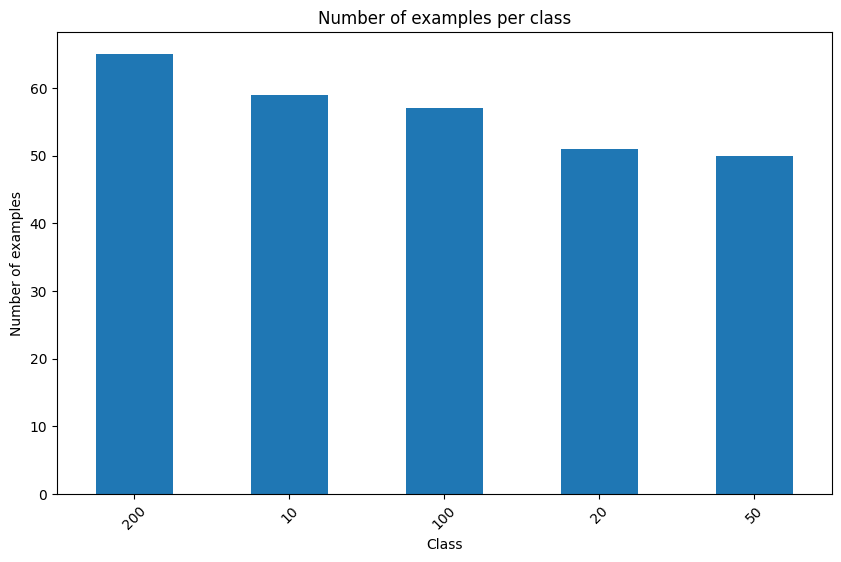

In [4]:
import matplotlib.pyplot as plt

# Count the number of examples per class
label_counts = df['label'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Number of examples per class')
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.xticks(rotation=45)
plt.show()


# Preprocessing steps

In [5]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom
)
import tensorflow as tf

from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        #opened_img = image_preprocesses(np.asarray(image))
        # Check the number of channels in the image
        if len(np.asarray(image).shape) == 2:  # Grayscale image
            # Duplicate the single channel to create a three-channel image
            image_rgb = np.stack((np.asarray(image),) * 3, axis=-1)
        else:  # Color image
            # Convert the image to RGB if it's not already in RGB mode
            if image.mode != "RGB":
                image = image.convert("RGB")
            # Convert the RGB image to array
            image_rgb = np.asarray(image)
        # Preprocess the image
        preprocessed_img = image_preprocesses(image_rgb)
        #print(preprocessed_img.shape)
    return preprocessed_img
    #return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

In [6]:
import matplotlib.pyplot as plt
import numpy as np

original_images = open_images(df['path'])
original_labels = df['label']

preprocessed_images = open_images(df['path'])
augmented_images = augment_images(preprocessed_images)
# Replicate original labels for augmented images
augmented_labels = np.tile(original_labels, (len(image_augmentations.layers) + 1, 1)).flatten()[:len(augmented_images)]

all_img = np.concatenate((original_images, augmented_images), axis=0)
all_labels = np.concatenate((original_labels, augmented_labels), axis=0)


In [7]:
original_images.shape

(282, 224, 224, 3)

In [8]:

#fig, axes = plt.subplots(5,5, figsize=(10, 10))
#
#axes = axes.flatten()
#for i in range(25):
#    axes[i].imshow(augmented_images[i][0])
#    axes[i].imshow(original_images[i])
#
#    axes[i].set_title(all_labels[i])
#    axes[i].axis('off')
#
#plt.tight_layout()
#plt.show()

In [9]:

#num_rows = 5
#num_cols = 8
#total_images = num_rows * num_cols
#
#augmented_images_subset = augment_images(preprocessed_images)
#
#fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
#axes = axes.flatten()
#for i in range(total_images):
#    axes[i].imshow(augmented_images_subset[i])
#    axes[i].set_title(f"Augmented Image {i+1}")
#    axes[i].axis('off')
#
#plt.tight_layout()
#plt.show()

## Define model

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import(
    GlobalAveragePooling2D,
    Dense,
    Dropout)


# Manually schedule the learning rate according to a predefined function.

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1 

callbacks = [LearningRateScheduler(schedule=lr_schedule, verbose=1)]


# dynamically adjust the lr 
#callbacks = [
#   ReduceLROnPlateau(
#       monitor='val_loss',  # Metric to monitor (validation loss in this case)
#       factor=0.1,          # Factor by which the learning rate will be reduced. new_lr = lr * factor
#       patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
#       min_lr=1e-8          # Lower bound on the learning rate
#   )]
NUM_CLASSES = len(QUERIES)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        # Use GlobalAveragePooling2D instead of Flatten for class activation map later on
        GlobalAveragePooling2D(),
        # Add a dense layer with 128 units and ReLU activation
        Dense(210, kernel_regularizer = tf.keras.regularizers.l2(l = 0.001),
                   activity_regularizer=tf.keras.regularizers.l1(0.0001),
                   bias_regularizer=tf.keras.regularizers.l1(0.0001),activation='relu'),
        Dropout(0,6),
        # Add the final output layer with softmax activation for classification
        Dense(NUM_CLASSES, activation='softmax')]
    
    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

model = get_model()



In [11]:
get_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

# Model training

In [12]:
from sklearn.preprocessing import LabelEncoder

num_samples = len(all_labels)

# Create an array of shuffled indices
shuffled_indices = np.arange(num_samples)
np.random.shuffle(shuffled_indices)

# Shuffle the images and labels using the shuffled indices
totalset = all_img[shuffled_indices]
labels = all_labels[shuffled_indices]

# transform labels in integer
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

NB_EPOCHS = 8

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_idx, test_idx in KFold(n_splits=3).split(totalset, labels):
    
    model = get_model() # We reinitialize the model
    
    # Train the model with the learning rate scheduler callback
    history = model.fit(
        x=totalset[train_idx],
        y=labels[train_idx],
        batch_size=32,
        callbacks=callbacks,
        validation_data=[totalset[test_idx], labels[test_idx]],
        epochs=NB_EPOCHS,
        verbose=True)
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

#save model here
model.save('bank.keras')



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/8
12/12 [==============================] - 16s 926ms/step - loss: 1.5075 - acc: 0.6170 - val_loss: 0.8120 - val_acc: 0.7766 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/8
12/12 [==============================] - 9s 770ms/step - loss: 0.6890 - acc: 0.8617 - val_loss: 0.5343 - val_acc: 0.9415 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/8
12/12 [==============================] - 9s 772ms/step - loss: 0.5515 - acc: 0.9149 - val_loss: 0.6171 - val_acc: 0.8883 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/8
12/12 [==============================] - 9s 763ms/step - loss: 0.4545 - acc: 0.9548 - val_loss: 0.4720 - val_acc: 0.9468 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/8
12/12 [======

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('bank.keras')

In [ ]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


In [ ]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

In [ ]:

totalset = open_images(df['path'])
labels = df['label']
# we re open the main dataset to perform k-fold predictions so we need to shuffle once again the whole business

In [ ]:
from sklearn.preprocessing import LabelEncoder

num_samples = len(labels)

# Create an array of shuffled indices
shuffled_indices = np.arange(num_samples)
np.random.shuffle(shuffled_indices)

# Shuffle the images and labels using the shuffled indices
totalset = totalset[shuffled_indices]
labels = labels[shuffled_indices]

# transform labels in integer
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)

fig, axes = plt.subplots(5,5, figsize=(10, 10))

axes = axes.flatten()
for i in range(25):
    axes[i].imshow(totalset[i])

    axes[i].set_title(labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Evaluation du modèle

In [ ]:
import numpy as np
import sklearn.metrics as me
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

labels = np.array(labels)

f1_scores = []
mean_confusion_matrix = np.zeros((len(QUERIES), len(QUERIES)))
model = get_model()
i = 1

for train_idx, test_idx in KFold(n_splits=3).split(totalset, labels):

    model.fit(totalset[train_idx], labels[train_idx])
    predicted_probabilities = model.predict(totalset[test_idx])
    predictions = np.argmax(predicted_probabilities, axis=1)
    true_labels = labels[test_idx]
    
    cm = confusion_matrix(true_labels, predictions, labels=np.arange(len(QUERIES)))
    mean_confusion_matrix += cm
    
    pl.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=QUERIES, yticklabels=QUERIES)
    pl.show()
    
    f1 = me.f1_score(true_labels, predictions, average='micro')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i}: {f1:.3f}")
    i += 1

mean_f1_score = np.mean(f1_scores)
mean_confusion_matrix /= 3
print(f"Mean F1 Score across all folds: {mean_f1_score:.3f}")

pl.figure(figsize=(5, 5))
sns.heatmap(mean_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=QUERIES, yticklabels=QUERIES)
pl.show()


# Load model from disk and export it as .TFLITE file

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('bank.keras')

In [ ]:
import tensorflow as tf
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils
import os

# Load the Keras model
model_path = "bank.keras"
model = tf.keras.models.load_model(model_path)

# Convert the loaded Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
SAVE_TO_PATH = "C:\\Users\\Julien\\Documents\\HEIG-VD\\S4_2024\\ARN\\pw_ARN_24\\pw6\\MyModel.tflite"
with open(SAVE_TO_PATH, 'wb') as f:
    f.write(tflite_model)

# Task Library expects label files that are in the same format as the one below.
LABEL_FILE = "labels.txt"

# Create the labels file
with open(LABEL_FILE, 'w') as label_file:
    for label in QUERIES:
        label_file.write("{}\n".format(label))

# Define ImageClassifierWriter
ImageClassifierWriter = image_classifier.MetadataWriter

# Normalization parameters required when preprocessing the image.
# Optional if the image pixel values are in the range [0, 255] and the input tensor is quantized to uint8.
INPUT_NORM_MEAN = 127.5
INPUT_NORM_STD = 127.5

# Create the metadata writer
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(SAVE_TO_PATH),
    [INPUT_NORM_MEAN],
    [INPUT_NORM_STD],
    [LABEL_FILE]
)

# Verify the metadata generated by the metadata writer
print(writer.get_metadata_json())

# Populate the metadata into the model
writer_utils.save_file(writer.populate(), SAVE_TO_PATH)


### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 50

fig, axs = plt.subplots(nb_images_per_class, len(QUERIES), figsize=(len(QUERIES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(QUERIES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in df[df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1